Initial model fit

// Predicitng the stock market (or our chosen securities): //

Where predicting the direction of a stock is a binary decision: 

    Will it go:
        
        Up?
        
        Down? 

Naturally we are trying to buy low and sell high -- possibly Machine Learning can help us here.



This is an oversimplification, however where we consider that flipping a coin is a binary decision, 

statistically, where flipped enough times, we will see heads and tails equally appear 50% of the time. 

    - This gives us 50% accuracy as our baseline for 0.

Given that, an accuracy of 50% is the same as if we were to assign Heads = Up and Tails = Down and apply that logic to whether we invest or not. 



Therefore this project seeks to determine whether a simple LinearRegression model: 

    - Using ~10 years of historical data

    - For BTC (Cryptocurrency known for volatility)

    - For VIT (Vanguard Information Technology Index Fund ETF -- Based on US IT company stock values)

Can:

A: Predict whether our chosen securities will be up/down after 14 days if presented with ~10 years of historical data for each. 

B: Use the relationships across VIT (yfTicker: 'VGT') and BTC (yfTicker: 'BTC-USD' - Cryptocurrency known for volatility) to better predict the direction of either in any way. 



The goal then is for our models to be able to predict the direction of either stock >50% of the time 14 days into the future. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

df_vit = pd.read_csv('Data\VIT_history2014-09-17_to_2024-11-11.csv')
df_btc = pd.read_csv('Data\BTC_history2014-09-17_to_2024-11-11.csv')


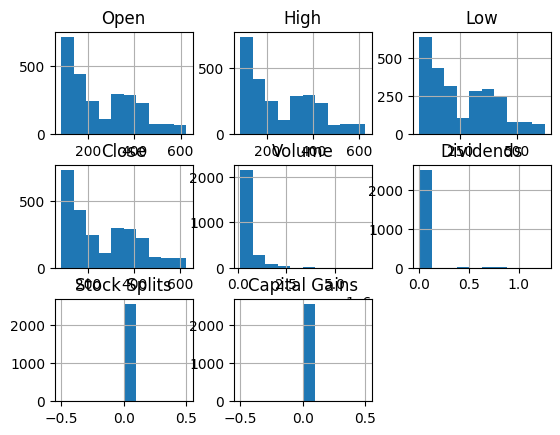

In [2]:
df_vit.hist();

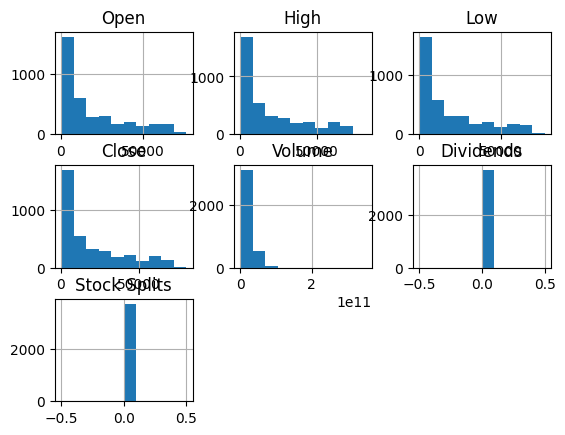

In [3]:
df_btc.hist();

In [4]:
df_vit['Date'] = pd.to_datetime(df_vit['Date'], utc=True)
df_btc['Date'] = pd.to_datetime(df_btc['Date'], utc=True)

df_vit['Date'] = df_vit['Date'].dt.strftime('%Y-%m-%d')
df_btc['Date'] = df_btc['Date'].dt.strftime('%Y-%m-%d')

In [5]:
# Adding flag for BTC, VIT in the joined dataset
df_vit['Stock'] = 'VIT'
df_btc['Stock'] = 'BTC'


# Dropping redundant columns for each dataset
# Stock splits & Capital Gains are always 0
df_vit.drop(['Stock Splits', 'Capital Gains'], axis=1, inplace=True)
# Capital Gains does not exist in the BTC table
df_btc.drop(['Stock Splits'], axis=1, inplace=True)

# joining the datasets -- This seemed useful but now causes problems, simply repeating for each dataset.
df = pd.concat([df_vit, df_btc], ignore_index=True)

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock
0,2014-09-17,91.473408,91.997347,91.139165,91.599876,231900,0.0,VIT
1,2014-09-18,91.888929,92.250272,91.780525,92.232201,231100,0.0,VIT
2,2014-09-19,92.521290,92.521290,91.455334,91.834747,198900,0.0,VIT
3,2014-09-22,91.717278,91.717278,90.750692,91.012665,271000,0.0,VIT
4,2014-09-23,90.750715,91.193355,90.678445,90.732651,268200,0.0,VIT


In [6]:
# Adding additional nodes to help with Model training


# // for VIT //
# Adding Moving Averages:
df_vit.loc[:, 'SMA_7'] = df_vit['Close'].rolling(window=7).mean()
df_vit.loc[:, 'SMA_14'] = df_vit['Close'].rolling(window=14).mean()
df_vit.loc[:, 'SMA_30'] = df_vit['Close'].rolling(window=30).mean()


# Adding considerations for volatility by Average/True Rating
high_low = df_vit['High'] - df_vit['Low']
high_close = (df_vit['High'] - df_vit['Close'].shift()).abs()
low_close = (df_vit['Low'] - df_vit['Close'].shift()).abs()
df_vit.loc[:, 'TR'] = high_low.combine(high_close, max).combine(low_close, max)
df_vit.loc[:, 'ATR_14'] = df_vit['TR'].rolling(window=14).mean()

# Tracking change in price
df_vit.loc[:, 'Price_Change'] = df_vit['Close'] - df_vit['Open']
df_vit.loc[:, 'Price_Change_pct'] = (
    df_vit['Close'] - df_vit['Open']) / df_vit['Open'] * 100


# // for BTC //
# Adding Moving Averages:
df_btc.loc[:, 'SMA_7'] = df_btc['Close'].rolling(window=7).mean()
df_btc.loc[:, 'SMA_14'] = df_btc['Close'].rolling(window=14).mean()
df_btc.loc[:, 'SMA_30'] = df_btc['Close'].rolling(window=30).mean()


# Adding considerations for volatility by Average/True Rating
high_low = df_btc['High'] - df_btc['Low']
high_close = (df_btc['High'] - df_btc['Close'].shift()).abs()
low_close = (df_btc['Low'] - df_btc['Close'].shift()).abs()
df_btc.loc[:, 'TR'] = high_low.combine(high_close, max).combine(low_close, max)
df_btc.loc[:, 'ATR_14'] = df_btc['TR'].rolling(window=14).mean()

# Tracking change in price
df_btc.loc[:, 'Price_Change'] = df_btc['Close'] - df_btc['Open']
df_btc.loc[:, 'Price_Change_pct'] = (
    df_btc['Close'] - df_btc['Open']) / df_btc['Open'] * 100

# // For all data //
# Adding Moving Averages:
df.loc[:, 'SMA_7'] = df['Close'].rolling(window=7).mean()
df.loc[:, 'SMA_14'] = df['Close'].rolling(window=14).mean()
df.loc[:, 'SMA_30'] = df['Close'].rolling(window=30).mean()


# Adding considerations for volatility by Average/True Rating
high_low = df['High'] - df['Low']
high_close = (df['High'] - df['Close'].shift()).abs()
low_close = (df['Low'] - df['Close'].shift()).abs()
df.loc[:, 'TR'] = high_low.combine(high_close, max).combine(low_close, max)
df.loc[:, 'ATR_14'] = df['TR'].rolling(window=14).mean()

# Tracking change in price
df.loc[:, 'Price_Change'] = df['Close'] - df['Open']
df.loc[:, 'Price_Change_pct'] = (df['Close'] - df['Open']) / df['Open'] * 100


# print(df_vit.head(25))
# print(df_btc.head(25))

In [7]:

df_btc.head(25)

,Date,Open,High,Low,Close,Volume,Dividends,Stock,SMA_7,SMA_14,SMA_30,TR,ATR_14,Price_Change,Price_Change_pct
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.0,BTC,NaN,NaN,NaN,15.752014,NaN,-8.529999,-1.831006
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.0,BTC,NaN,NaN,NaN,44.230011,NaN,-32.419983,-7.096262
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.0,BTC,NaN,NaN,NaN,43.302979,NaN,-29.307007,-6.910351
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.0,BTC,NaN,NaN,NaN,33.412994,NaN,14.230988,3.605767
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.0,BTC,NaN,NaN,NaN,19.244995,NaN,-9.263977,-2.270110
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600,0.0,BTC,NaN,NaN,NaN,9.785980,NaN,3.052002,0.764721
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500,0.0,BTC,417.462572,NaN,NaN,45.360016,NaN,33.698975,8.380911
7,2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700,0.0,BTC,412.586997,NaN,NaN,14.980011,NaN,-12.546021,-2.879172
8,2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400,0.0,BTC,410.748997,NaN,NaN,14.052002,NaN,-11.582001,-2.737052
9,2014-09-26,411.428986,414.937988,400.009003,404.424988,21460800,0.0,BTC,412.124568,NaN,NaN,14.928986,NaN,-7.003998,-1.702359


In [8]:
df_vit_sns = df_vit.drop(columns=['Date', 'Stock'], axis=1)
df_btc_sns = df_btc.drop(columns=['Date', 'Stock'], axis=1)
df_sns = df.drop(columns=['Date', 'Stock'], axis=1)

<Axes: >

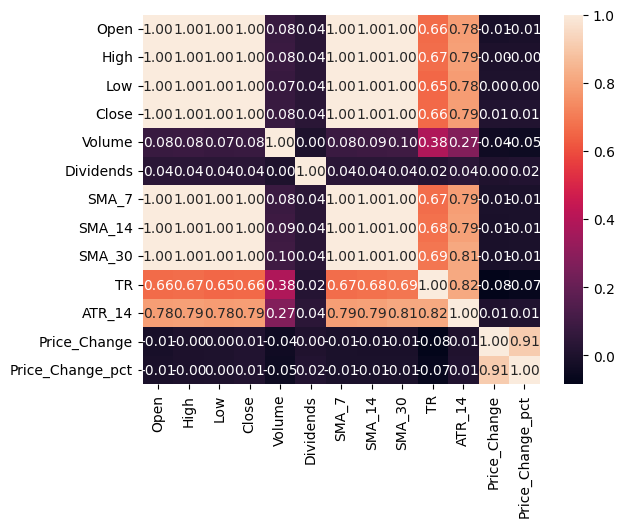

In [9]:
sns.heatmap(df_vit_sns.corr(), annot=True, fmt='.2f')

<Axes: >

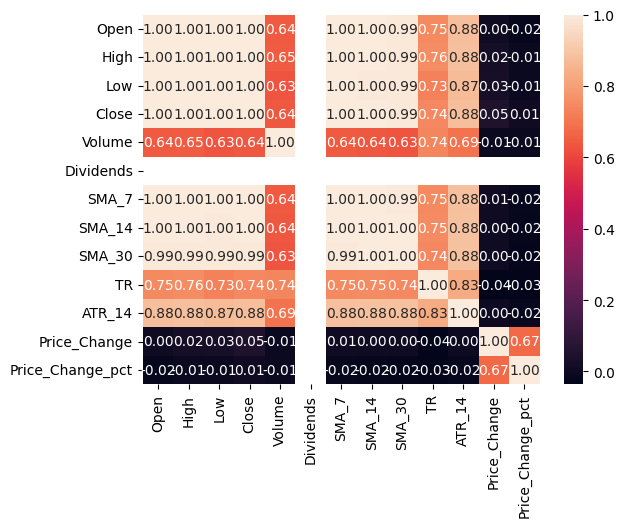

In [10]:
sns.heatmap(df_btc_sns.corr(), annot=True, fmt='.2f')

<Axes: >

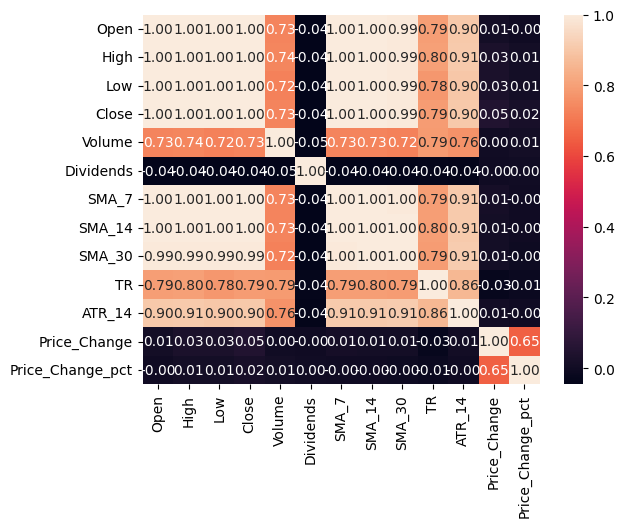

In [11]:
sns.heatmap(df_sns.corr(), annot=True, fmt='.2f')

In [12]:
# Applying Linear Regression model for BTC


df_btc['Date'] = pd.to_datetime(df_btc['Date'])
df_btc['Date_numeric'] = (df_btc['Date'] - pd.Timestamp('2014-09-16')).dt.days

df_btc['14_days_ahead'] = df_btc['Date_numeric'] + 14
df_btc['close_7_days_ahead'] = df_btc['Close'].shift(-7)
df_btc['close_14_days_ahead'] = df_btc['Close'].shift(-14)
df_btc = df_btc.dropna()

# Feeding the model everything except for 14 days ahead...
X = df_btc[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'SMA_7', 'SMA_14', 'SMA_30', 'TR',
            'ATR_14', 'Price_Change', 'Price_Change_pct', 'Date_numeric', '14_days_ahead', 'close_7_days_ahead']]
y = df_btc['close_14_days_ahead']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


X_train, X_test = X.iloc[:-14], X.iloc[-14:]
y_train, y_test = y.iloc[:-14], y.iloc[-14:]

lm_model = LinearRegression()

lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Creating empty lists to store results
r2_scores_test = []
r2_scores_train = []

r2_scores_test.append(r2_score(y_test, y_test_preds))
r2_scores_train.append(r2_score(y_train, y_train_preds))

print('R^2:', r2_score(y_test, y_test_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_preds)))

R^2: -1.2155073394057463
RMSE: 5585.022719973411


Test R^2: -1.22, Test RMSE: 5585.02
Train R^2: 0.99, Train RMSE: 2301.70


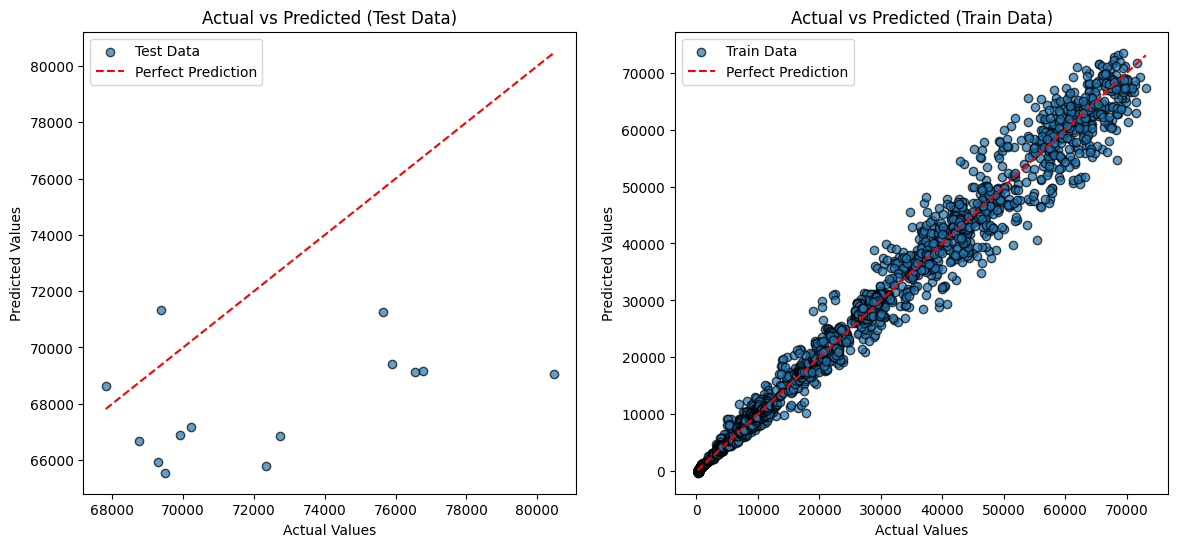

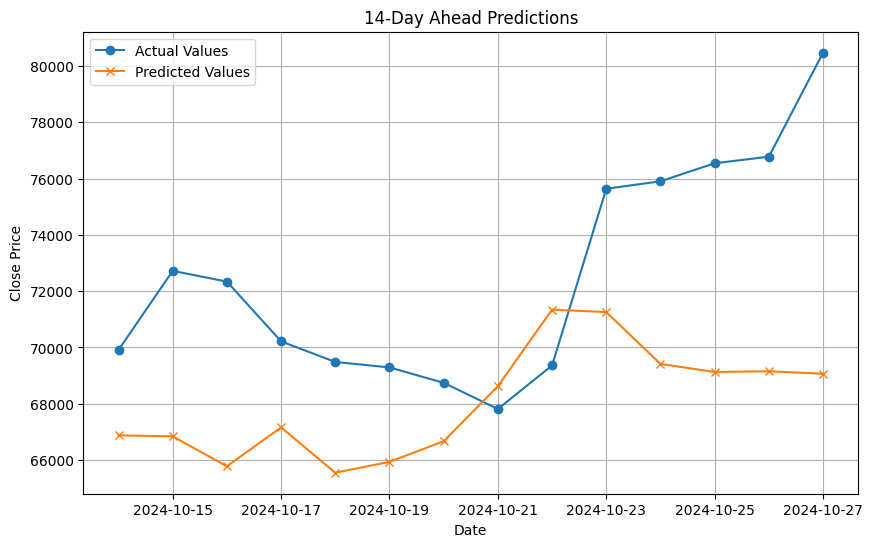

Directional Accuracy: 35.71%


In [13]:
# Creating metrics to evaluate model performance
# See outputs below

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))

test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)

print(f"Test R^2: {test_r2:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}, Train RMSE: {train_rmse:.2f}")

# Plotting
plt.figure(figsize=(14, 6))

# Test data
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_preds, alpha=0.7, edgecolor='k', label='Test Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Train data
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_preds, alpha=0.7,
            edgecolor='k', label='Train Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(),
         y_train.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Train Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()


plt.show()

# showing accuracy of predictions:
plt.figure(figsize=(10, 6))
plt.plot(df_btc['Date'].iloc[-14:], y_test, label='Actual Values', marker='o')
plt.plot(df_btc['Date'].iloc[-14:], y_test_preds,
         label='Predicted Values', marker='x')
plt.title('14-Day Ahead Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()

# plt.xticks(df_btc_vit['Date'][::5], rotation=45) #Had to adjust date interval to avoid overcrowing the x-axis

plt.show()


# Importantly, was the model able to predict the direction of the price movement?
y_test_preds_series = pd.Series(y_test_preds, index=y_test.index)

# Did it go up or down?
direction_actual = np.sign(y_test.diff().fillna(0))
direction_predicted = np.sign(y_test_preds_series.diff().fillna(0))

# Compare the predicted direction to the actual direction
correct_direction = (direction_actual == direction_predicted).sum()

# Calculate the percentage of correct directional predictions
directional_accuracy = correct_direction / len(y_test) * 100

print(f'Directional Accuracy: {directional_accuracy:.2f}%')

In [14]:
# /// And now the same for VIT ///

# Applying Linear Regression model for VIT

df_vit['Date'] = pd.to_datetime(df_vit['Date'])
df_vit['Date_numeric'] = (df_vit['Date'] - pd.Timestamp('2014-09-16')).dt.days

df_vit['14_days_ahead'] = df_vit['Date_numeric'] + 14
df_vit['close_7_days_ahead'] = df_vit['Close'].shift(-7)
df_vit['close_14_days_ahead'] = df_vit['Close'].shift(-14)
df_vit = df_vit.dropna()

# Feeding the model everything except for 14 days ahead...
X = df_vit[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'SMA_7', 'SMA_14', 'SMA_30', 'TR',
            'ATR_14', 'Price_Change', 'Price_Change_pct', 'Date_numeric', '14_days_ahead', 'close_7_days_ahead']]
y = df_vit['close_14_days_ahead']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


X_train, X_test = X.iloc[:-14], X.iloc[-14:]
y_train, y_test = y.iloc[:-14], y.iloc[-14:]

lm_model = LinearRegression()

lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Creating empty lists to store results
r2_scores_test = []
r2_scores_train = []

r2_scores_test.append(r2_score(y_test, y_test_preds))
r2_scores_train.append(r2_score(y_train, y_train_preds))

print('R^2:', r2_score(y_test, y_test_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_preds)))

R^2: 0.13994861263588043
RMSE: 11.75685799288528


Test R^2: 0.14, Test RMSE: 11.76
Train R^2: 0.99, Train RMSE: 10.84


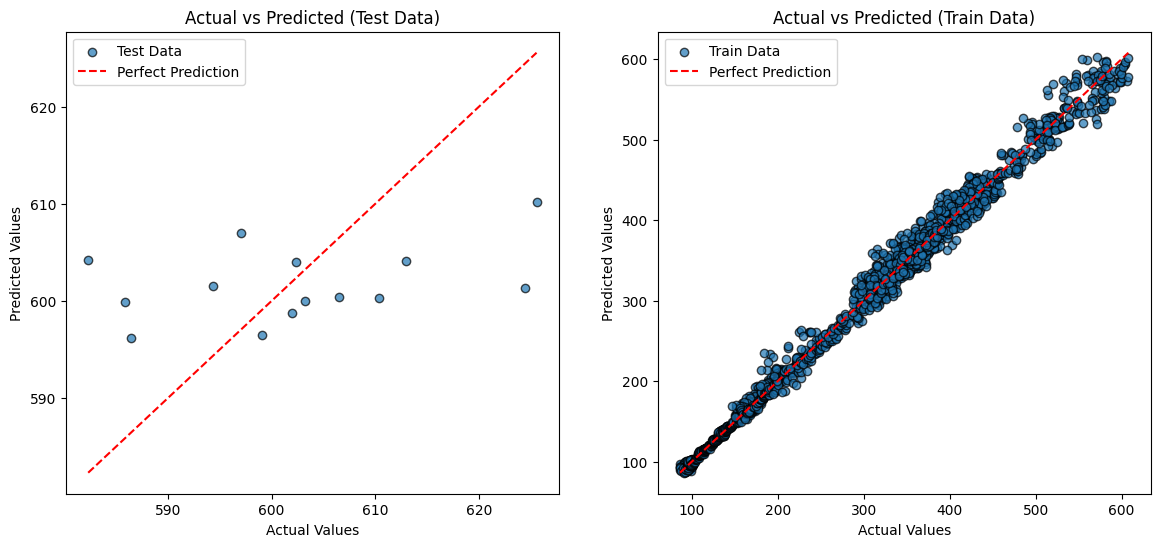

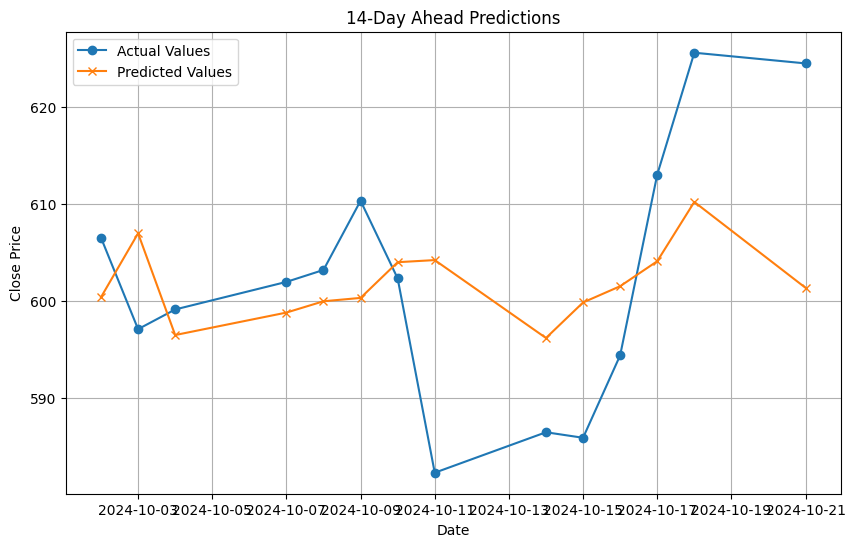

Directional Accuracy: 57.14%


In [15]:
# Creating metrics to evaluate model performance
# See outputs below

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))

test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)

print(f"Test R^2: {test_r2:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}, Train RMSE: {train_rmse:.2f}")

# Plotting
plt.figure(figsize=(14, 6))

# Test data
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_preds, alpha=0.7, edgecolor='k', label='Test Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Train data
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_preds, alpha=0.7,
            edgecolor='k', label='Train Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(),
         y_train.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Train Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()


plt.show()

# showing accuracy of predictions:
plt.figure(figsize=(10, 6))
plt.plot(df_vit['Date'].iloc[-14:], y_test, label='Actual Values', marker='o')
plt.plot(df_vit['Date'].iloc[-14:], y_test_preds,
         label='Predicted Values', marker='x')
plt.title('14-Day Ahead Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()

# plt.xticks(df_vit_vit['Date'][::5], rotation=45) #Had to adjust date interval to avoid overcrowing the x-axis

plt.show()


# Importantly, was the model able to predict the direction of the price movement?
y_test_preds_series = pd.Series(y_test_preds, index=y_test.index)

# Did it go up or down?
direction_actual = np.sign(y_test.diff().fillna(0))
direction_predicted = np.sign(y_test_preds_series.diff().fillna(0))

# Compare the predicted direction to the actual direction
correct_direction = (direction_actual == direction_predicted).sum()

# Calculate the percentage of correct directional predictions
directional_accuracy = correct_direction / len(y_test) * 100

print(f'Directional Accuracy: {directional_accuracy:.2f}%')

In [16]:
# // Applying the same for the entire dataset //

# Applying Linear Regression model for all data
df['Date'] = pd.to_datetime(df['Date'])
df['Date_numeric'] = (df['Date'] - pd.Timestamp('2014-09-16')).dt.days
df.sort_values('Date_numeric', inplace=True)

df['14_days_ahead'] = df['Date_numeric'] + 14
df['close_7_days_ahead'] = df['Close'].shift(-7)
df['close_14_days_ahead'] = df['Close'].shift(-14)
df = df.dropna()

# Feeding the model everything except for 14 days ahead...
X = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'SMA_7', 'SMA_14', 'SMA_30', 'TR',
        'ATR_14', 'Price_Change', 'Price_Change_pct', 'Date_numeric', '14_days_ahead', 'close_7_days_ahead']]
y = df['close_14_days_ahead']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


X_train, X_test = X.iloc[:-14], X.iloc[-14:]
y_train, y_test = y.iloc[:-14], y.iloc[-14:]

lm_model = LinearRegression()

lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Creating empty lists to store results
r2_scores_test = []
r2_scores_train = []

r2_scores_test.append(r2_score(y_test, y_test_preds))
r2_scores_train.append(r2_score(y_train, y_train_preds))

print('R^2:', r2_score(y_test, y_test_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_preds)))

R^2: -0.3133455802777716
RMSE: 40165.412945402786


Test R^2: -0.31, Test RMSE: 40165.41
Train R^2: 0.36, Train RMSE: 14386.85


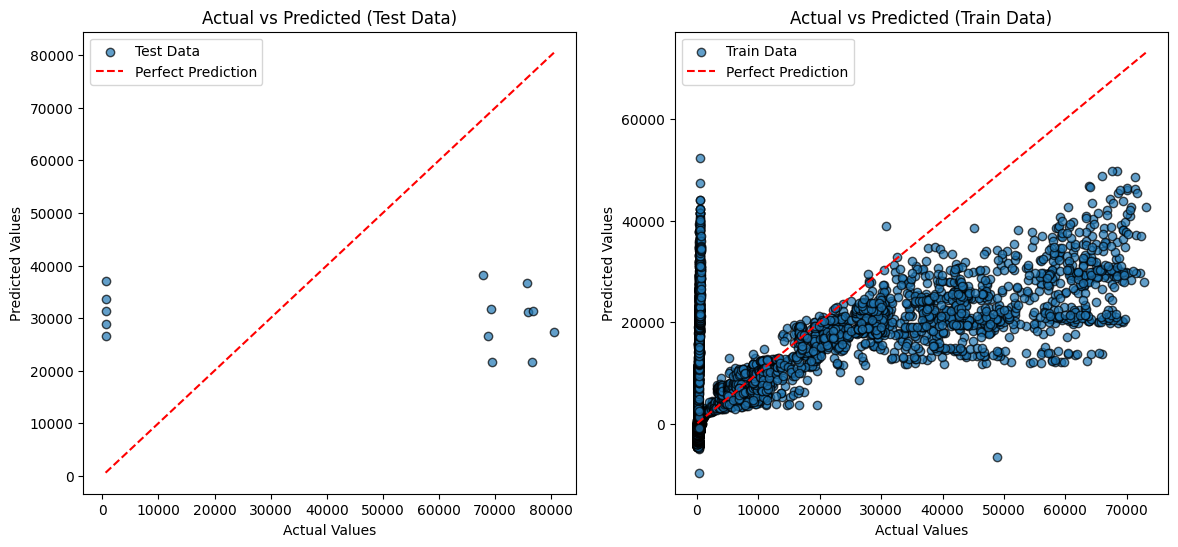

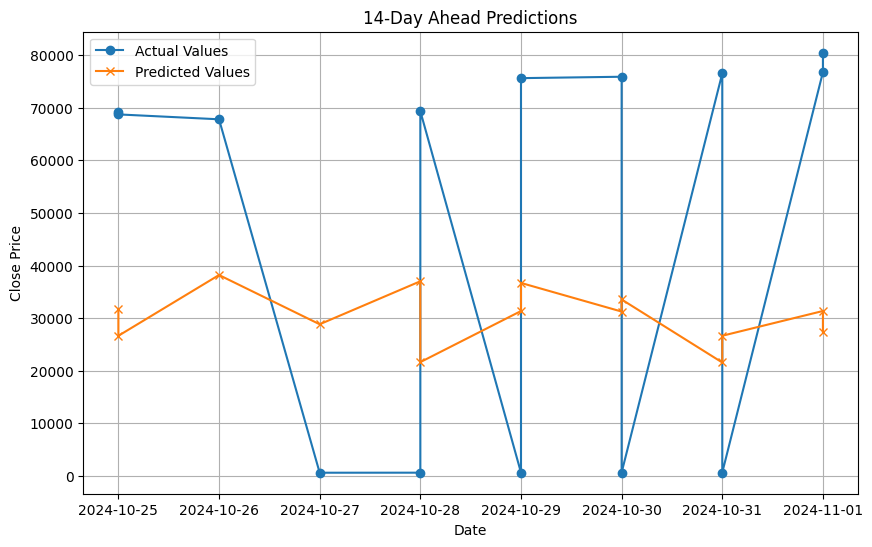

Directional Accuracy: 42.86%


In [17]:
# Creating metrics to evaluate model performance
# See outputs below

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))

test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)

print(f"Test R^2: {test_r2:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}, Train RMSE: {train_rmse:.2f}")

# Plotting
plt.figure(figsize=(14, 6))

# Test data
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_preds, alpha=0.7, edgecolor='k', label='Test Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Train data
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_preds, alpha=0.7,
            edgecolor='k', label='Train Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(),
         y_train.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Train Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()


plt.show()

# showing accuracy of predictions:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'].iloc[-14:], y_test, label='Actual Values', marker='o')
plt.plot(df['Date'].iloc[-14:], y_test_preds,
         label='Predicted Values', marker='x')
plt.title('14-Day Ahead Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()

# plt.xticks(df_vit['Date'][::5], rotation=45) #Had to adjust date interval to avoid overcrowing the x-axis

plt.show()


# Importantly, was the model able to predict the direction of the price movement?
y_test_preds_series = pd.Series(y_test_preds, index=y_test.index)

# Did it go up or down?
direction_actual = np.sign(y_test.diff().fillna(0))
direction_predicted = np.sign(y_test_preds_series.diff().fillna(0))

# Compare the predicted direction to the actual direction
correct_direction = (direction_actual == direction_predicted).sum()

# Calculate the percentage of correct directional predictions
directional_accuracy = correct_direction / len(y_test) * 100

print(f'Directional Accuracy: {directional_accuracy:.2f}%')

We can see that this is utterly useless, however if we try to bring the datasets together and use their percentage values we may be able to see some better results.

In [18]:
# Converting to percentage where possible
# for analysis on min/max value basis between the data sets
# Given that we have seen in our exploration that they appear to act at least in some way consistenly
# across their percentage values


# For BTC
close_max = df_btc['Close'].max()
close_min = df_btc['Close'].min()

# Create a new DataFrame with a copy of the original
df_btc_percentage = df_btc.copy()

# Apply the normalization only to numeric columns
for col in df_btc_percentage.select_dtypes(include=['number']).columns:
    df_btc_percentage[col] = (
        df_btc_percentage[col] - close_min) / (close_max - close_min) * 100


df_btc_percentage.head(31)

# For VIT
close_max = df_vit['Close'].max()
close_min = df_vit['Close'].min()

# Create a new DataFrame with a copy of the original
df_vit_percentage = df_vit.copy()

# Apply the normalization only to numeric columns
for col in df_vit_percentage.select_dtypes(include=['number']).columns:
    df_vit_percentage[col] = (
        df_vit_percentage[col] - close_min) / (close_max - close_min) * 100

df_vit_percentage.head(31)

,Date,Open,High,Low,Close,Volume,Dividends,Stock,SMA_7,SMA_14,SMA_30,TR,ATR_14,Price_Change,Price_Change_pct,Date_numeric,14_days_ahead,close_7_days_ahead,close_14_days_ahead
29,2014-10-28,0.565961,0.794551,0.564229,0.794551,53218.969806,-16.531497,VIT,0.351225,0.080331,0.450511,-16.250960,-16.219166,-16.302908,-16.275196,-8.480035,-5.796214,1.267315,1.516687
30,2014-10-29,0.759912,0.818792,0.645618,0.747790,63666.700526,-16.531497,VIT,0.474425,0.106801,0.441159,-16.358323,-16.229556,-16.543619,-16.544936,-8.288334,-5.604513,1.265580,1.618859
31,2014-10-30,0.706228,0.851694,0.669862,0.818791,37231.066282,-16.531497,VIT,0.556312,0.174586,0.430134,-16.349666,-16.252812,-16.418934,-16.406315,-8.096632,-5.412811,1.326192,1.488973
32,2014-10-31,1.049116,1.139167,1.040458,1.130508,52490.504178,-16.531497,VIT,0.700788,0.279109,0.432039,-16.211121,-16.254296,-16.450105,-16.442746,-7.904931,-5.221110,1.346975,1.608466
33,2014-11-03,1.180727,1.251729,1.130506,1.201508,69379.404663,-16.531497,VIT,0.817557,0.384622,0.441563,-16.410275,-16.264562,-16.510716,-16.509005,-7.329826,-4.646005,1.395465,1.651759
34,2014-11-04,1.203237,1.258653,1.102796,1.213627,44573.233008,-16.531497,VIT,0.917256,0.495329,0.453282,-16.375641,-16.285096,-16.521107,-16.520266,-7.138125,-4.454304,1.454342,1.790301
35,2014-11-05,1.324469,1.324469,1.185929,1.251736,58759.142610,-16.531497,VIT,1.022644,0.613830,0.461998,-16.392958,-16.301176,-16.604230,-16.609583,-6.946423,-4.262602,1.580758,1.802421
36,2014-11-06,1.225754,1.270779,1.153021,1.267315,69053.512145,-16.531497,VIT,1.090182,0.720704,0.484338,-16.413739,-16.315525,-16.489936,-16.486629,-6.754722,-4.070901,1.516687,1.961742
37,2014-11-07,1.288094,1.291557,1.168604,1.265580,97981.265644,-16.531497,VIT,1.164152,0.819289,0.499865,-16.408544,-16.327152,-16.554011,-16.555717,-6.563020,-3.879200,1.618859,2.011963
38,2014-11-10,1.284629,1.345241,1.237873,1.326192,36943.514060,-16.531497,VIT,1.236638,0.896475,0.517991,-16.424129,-16.345335,-16.489935,-16.486776,-5.987916,-3.304095,1.488973,1.785100


In [19]:
# joining the datasets now as percentages
df_percentage = pd.concat(
    [df_vit_percentage, df_btc_percentage], ignore_index=True)

df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock,SMA_7,SMA_14,SMA_30,TR,ATR_14,Price_Change,Price_Change_pct,Date_numeric,14_days_ahead,close_7_days_ahead,close_14_days_ahead
2555,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.0,BTC,583.877716,591.674576,592.835137,172.047974,21.914132,-8.529999,-1.831006,1,15,91.012665,411.574005
2556,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.0,BTC,560.730578,579.342431,587.923803,44.230011,24.011276,-32.419983,-7.096262,2,16,402.152008,90.407448
2557,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.0,BTC,533.430001,564.747859,581.904336,43.302979,26.735062,-29.307007,-6.910351,3,17,91.401131,377.181000
2558,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.0,BTC,506.931998,550.958143,576.279801,33.412994,28.445988,14.230988,3.605767,4,18,423.204987,90.317093
2559,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.0,BTC,476.333570,536.360358,570.072503,19.244995,29.506348,-9.263977,-2.270110,5,19,89.350548,375.467010


In [20]:
# // Applying the same for the entire dataset as percentages //

# Applying Linear Regression model for all data
df_percentage['Date'] = pd.to_datetime(df_percentage['Date'])
df_percentage['Date_numeric'] = (
    df_percentage['Date'] - pd.Timestamp('2014-09-16')).dt.days
df_percentage.sort_values('Date_numeric', inplace=True)

df_percentage['14_days_ahead'] = df_percentage['Date_numeric'] + 14
df_percentage['close_7_days_ahead'] = df_percentage['Close'].shift(-7)
df_percentage['close_14_days_ahead'] = df_percentage['Close'].shift(-14)
df_percentage = df_percentage.dropna()

# Feeding the model everything except for 14 days ahead...
X = df_percentage[['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'SMA_7', 'SMA_14', 'SMA_30', 'TR',
                   'ATR_14', 'Price_Change', 'Price_Change_pct', 'Date_numeric', '14_days_ahead', 'close_7_days_ahead']]
y = df_percentage['close_14_days_ahead']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


X_train, X_test = X.iloc[:-14], X.iloc[-14:]
y_train, y_test = y.iloc[:-14], y.iloc[-14:]

lm_model = LinearRegression()

lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Creating empty lists to store results
r2_scores_test = []
r2_scores_train = []

r2_scores_test.append(r2_score(y_test, y_test_preds))
r2_scores_train.append(r2_score(y_train, y_train_preds))

print('R^2:', r2_score(y_test, y_test_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_preds)))

R^2: -2.2853378761648164
RMSE: 5.281469782107072


Test R^2: -2.29, Test RMSE: 5.28
Train R^2: 0.92, Train RMSE: 8.02


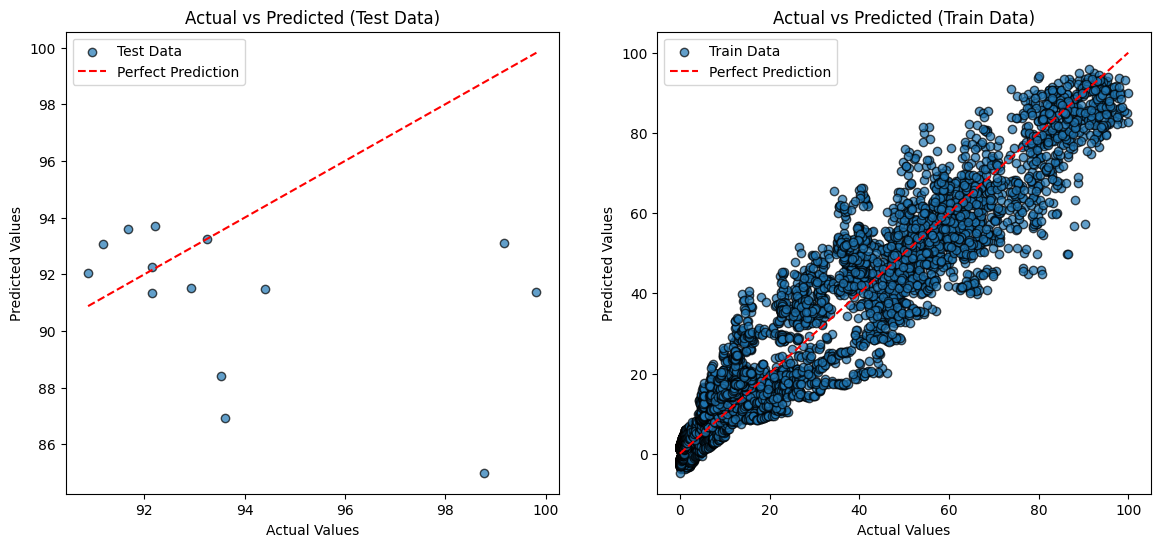

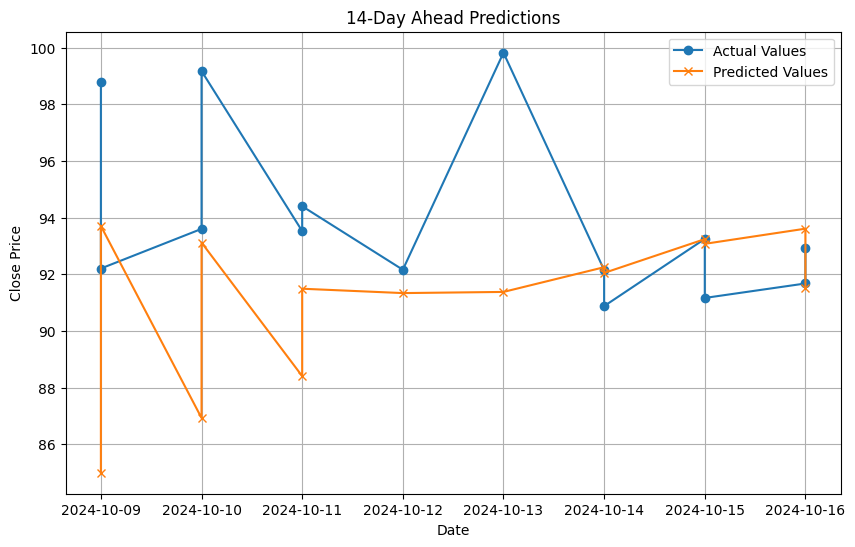

Directional Accuracy: 71.43%


In [21]:
# Creating metrics to evaluate model performance
# See outputs below

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))

test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)

print(f"Test R^2: {test_r2:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}, Train RMSE: {train_rmse:.2f}")

# Plotting
plt.figure(figsize=(14, 6))

# Test data
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_preds, alpha=0.7, edgecolor='k', label='Test Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Train data
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_preds, alpha=0.7,
            edgecolor='k', label='Train Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(),
         y_train.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Train Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()


plt.show()

# showing accuracy of predictions:
plt.figure(figsize=(10, 6))
plt.plot(df_percentage['Date'].iloc[-14:], y_test,
         label='Actual Values', marker='o')
plt.plot(df_percentage['Date'].iloc[-14:], y_test_preds,
         label='Predicted Values', marker='x')
plt.title('14-Day Ahead Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()

# plt.xticks(df_percentage_vit['Date'][::5], rotation=45) #Had to adjust date interval to avoid overcrowing the x-axis

plt.show()


# Importantly, was the model able to predict the direction of the price movement?
y_test_preds_series = pd.Series(y_test_preds, index=y_test.index)

# Did it go up or down?
direction_actual = np.sign(y_test.diff().fillna(0))
direction_predicted = np.sign(y_test_preds_series.diff().fillna(0))

# Compare the predicted direction to the actual direction
correct_direction = (direction_actual == direction_predicted).sum()

# Calculate the percentage of correct directional predictions
directional_accuracy = correct_direction / len(y_test) * 100

print(f'Directional Accuracy: {directional_accuracy:.2f}%')

In [22]:
df_vit_btc_percentage = pd.merge(
    df_btc_percentage, df_vit_percentage, on='Date', suffixes=('_vit', '_btc'))

# Applying the additional fields now that the data is merged

df_vit_btc_percentage['Date'] = pd.to_datetime(df_vit_btc_percentage['Date'])
df_vit_btc_percentage['Date_numeric'] = (
    df_vit_btc_percentage['Date'] - pd.Timestamp('2014-09-16')).dt.days
df_vit_btc_percentage.sort_values('Date_numeric', inplace=True)

df_vit_btc_percentage['14_days_ahead'] = df_vit_btc_percentage['Date_numeric'] + 14

df_vit_btc_percentage['close_7_days_ahead_btc'] = df_vit_btc_percentage['Close_btc'].shift(
    -7)
df_vit_btc_percentage['close_14_days_ahead_btc'] = df_vit_btc_percentage['Close_btc'].shift(
    -14)

df_vit_btc_percentage['close_7_days_ahead_vit'] = df_vit_btc_percentage['Close_vit'].shift(
    -7)
df_vit_btc_percentage['close_14_days_ahead_vit'] = df_vit_btc_percentage['Close_vit'].shift(
    -14)


df_vit_btc_percentage = df_vit_btc_percentage.dropna()

print(df_vit_btc_percentage.head())

        Date  Open_vit  High_vit   Low_vit  Close_vit    Volume_vit  \
0 2014-10-28  0.240191  0.249475  0.239456   0.246230  10761.482990   
1 2014-10-29  0.245504  0.246525  0.215677   0.216017  24953.601029   
2 2014-10-30  0.216179  0.237033  0.215305   0.229341  41392.987539   
3 2014-10-31  0.228935  0.233099  0.218144   0.219762  17207.535262   
4 2014-11-03  0.202270  0.213837  0.202150   0.204993  17760.443574   

   Dividends_vit Stock_vit  SMA_7_vit  SMA_14_vit  ...     TR_btc  ATR_14_btc  \
0      -0.244293       BTC   0.248028    0.267514  ... -16.250960  -16.219166   
1      -0.244293       BTC   0.238707    0.261716  ... -16.358323  -16.229556   
2      -0.244293       BTC   0.236138    0.258067  ... -16.349666  -16.252812   
3      -0.244293       BTC   0.232214    0.253615  ... -16.211121  -16.254296   
4      -0.244293       BTC   0.217368    0.235525  ... -16.410275  -16.264562   

   Price_Change_btc  Price_Change_pct_btc  Date_numeric_btc  \
0        -16.302908    

In [23]:
df_vit_btc_percentage.head(31)

,Date,Open_vit,High_vit,Low_vit,Close_vit,Volume_vit,Dividends_vit,Stock_vit,SMA_7_vit,SMA_14_vit,...,TR_btc,ATR_14_btc,Price_Change_btc,Price_Change_pct_btc,Date_numeric_btc,14_days_ahead_btc,close_7_days_ahead_btc,close_14_days_ahead_btc,Date_numeric,14_days_ahead
0,2014-10-28,0.240191,0.249475,0.239456,0.246230,10761.482990,-0.244293,BTC,0.248028,0.267514,...,-16.250960,-16.219166,-16.302908,-16.275196,-8.480035,-5.796214,1.267315,1.516687,42,56
1,2014-10-29,0.245504,0.246525,0.215677,0.216017,24953.601029,-0.244293,BTC,0.238707,0.261716,...,-16.358323,-16.229556,-16.543619,-16.544936,-8.288334,-5.604513,1.265580,1.618859,43,57
2,2014-10-30,0.216179,0.237033,0.215305,0.229341,41392.987539,-0.244293,BTC,0.236138,0.258067,...,-16.349666,-16.252812,-16.418934,-16.406315,-8.096632,-5.412811,1.326192,1.488973,44,58
3,2014-10-31,0.228935,0.233099,0.218144,0.219762,17207.535262,-0.244293,BTC,0.232214,0.253615,...,-16.211121,-16.254296,-16.450105,-16.442746,-7.904931,-5.221110,1.346975,1.608466,45,59
4,2014-11-03,0.202270,0.213837,0.202150,0.204993,17760.443574,-0.244293,BTC,0.217368,0.235525,...,-16.410275,-16.264562,-16.510716,-16.509005,-7.329826,-4.646005,1.395465,1.651759,48,62
5,2014-11-04,0.204454,0.210772,0.201595,0.209023,21473.474586,-0.244293,BTC,0.212052,0.230040,...,-16.375641,-16.285096,-16.521107,-16.520266,-7.138125,-4.454304,1.454342,1.790301,49,63
6,2014-11-05,0.209285,0.226686,0.209285,0.221359,27181.831129,-0.244293,BTC,0.212816,0.225761,...,-16.392958,-16.301176,-16.604230,-16.609583,-6.946423,-4.262602,1.580758,1.802421,50,64
7,2014-11-06,0.221321,0.239849,0.219903,0.234807,25782.483423,-0.244293,BTC,0.213596,0.224867,...,-16.413739,-16.315525,-16.489936,-16.486629,-6.754722,-4.070901,1.516687,1.961742,51,65
8,2014-11-07,0.235531,0.239528,0.224501,0.225377,23090.227321,-0.244293,BTC,0.214399,0.223307,...,-16.408544,-16.327152,-16.554011,-16.555717,-6.563020,-3.879200,1.618859,2.011963,52,66
9,2014-11-10,0.252604,0.269820,0.246152,0.258995,41766.348101,-0.244293,BTC,0.233304,0.225336,...,-16.424129,-16.345335,-16.489935,-16.486776,-5.987916,-3.304095,1.488973,1.785100,55,69


In [24]:
print(df_vit_btc_percentage.columns)

Index(['Date', 'Open_vit', 'High_vit', 'Low_vit', 'Close_vit', 'Volume_vit',
       'Dividends_vit', 'Stock_vit', 'SMA_7_vit', 'SMA_14_vit', 'SMA_30_vit',
       'TR_vit', 'ATR_14_vit', 'Price_Change_vit', 'Price_Change_pct_vit',
       'Date_numeric_vit', '14_days_ahead_vit', 'close_7_days_ahead_vit',
       'close_14_days_ahead_vit', 'Open_btc', 'High_btc', 'Low_btc',
       'Close_btc', 'Volume_btc', 'Dividends_btc', 'Stock_btc', 'SMA_7_btc',
       'SMA_14_btc', 'SMA_30_btc', 'TR_btc', 'ATR_14_btc', 'Price_Change_btc',
       'Price_Change_pct_btc', 'Date_numeric_btc', '14_days_ahead_btc',
       'close_7_days_ahead_btc', 'close_14_days_ahead_btc', 'Date_numeric',
       '14_days_ahead'],
      dtype='object')


In [25]:
# // Applying all the data to simply predict BTC //

# Applying Linear Regression model for all data

# Feeding the model everything except for 14 days ahead...
X = df_vit_btc_percentage[['Open_vit', 'High_vit', 'Low_vit', 'Close_vit', 'Volume_vit',
                           'Dividends_vit', 'SMA_7_vit', 'SMA_14_vit', 'SMA_30_vit',
                           'TR_vit', 'ATR_14_vit', 'Price_Change_vit', 'Price_Change_pct_vit',
                           'Open_btc', 'High_btc', 'Low_btc', 'Close_btc', 'Volume_btc',
                           'Dividends_btc', 'SMA_7_btc', 'SMA_14_btc', 'SMA_30_btc',
                           'TR_btc', 'ATR_14_btc', 'Price_Change_btc', 'Price_Change_pct_btc',
                           'Date_numeric', '14_days_ahead', 'close_7_days_ahead_btc', 'close_7_days_ahead_vit',
                           'close_14_days_ahead_vit']]

y = df_vit_btc_percentage['close_14_days_ahead_btc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


X_train, X_test = X.iloc[:-14], X.iloc[-14:]
y_train, y_test = y.iloc[:-14], y.iloc[-14:]

lm_model = LinearRegression()

lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Creating empty lists to store results
r2_scores_test = []
r2_scores_train = []

r2_scores_test.append(r2_score(y_test, y_test_preds))
r2_scores_train.append(r2_score(y_train, y_train_preds))

print('R^2:', r2_score(y_test, y_test_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_preds)))

R^2: -1.067724335695504
RMSE: 2.8454513701563795


Test R^2: -1.07, Test RMSE: 2.85
Train R^2: 0.99, Train RMSE: 1.97


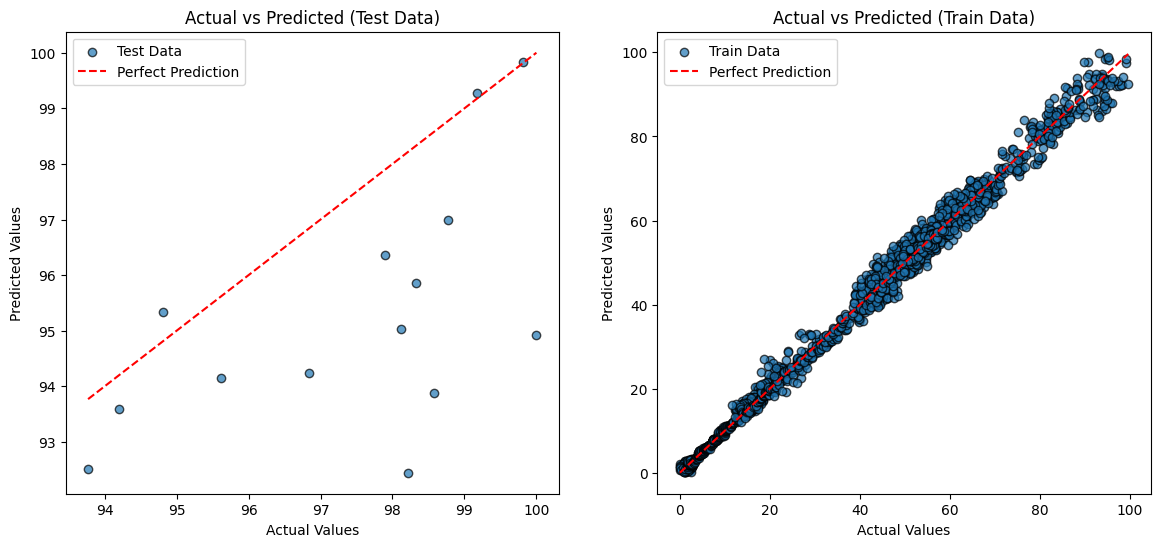

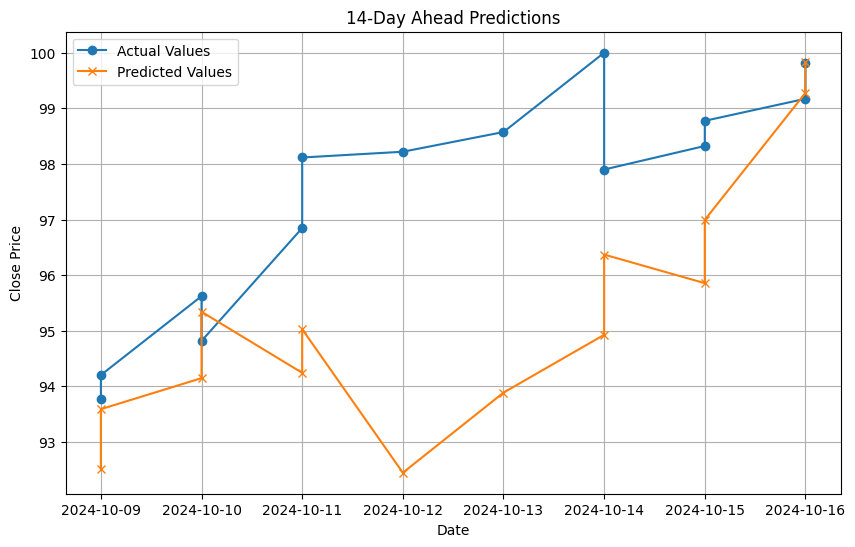

Directional Accuracy: 64.29%


In [26]:
# Creating metrics to evaluate model performance
# See outputs below

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))

test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)

print(f"Test R^2: {test_r2:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}, Train RMSE: {train_rmse:.2f}")

# Plotting
plt.figure(figsize=(14, 6))

# Test data
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_preds, alpha=0.7, edgecolor='k', label='Test Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Train data
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_preds, alpha=0.7,
            edgecolor='k', label='Train Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(),
         y_train.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Train Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()


plt.show()

# showing accuracy of predictions:
plt.figure(figsize=(10, 6))
plt.plot(df_percentage['Date'].iloc[-14:], y_test,
         label='Actual Values', marker='o')
plt.plot(df_percentage['Date'].iloc[-14:], y_test_preds,
         label='Predicted Values', marker='x')
plt.title('14-Day Ahead Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()

# plt.xticks(df_percentage_vit['Date'][::5], rotation=45) #Had to adjust date interval to avoid overcrowing the x-axis

plt.show()


# Importantly, was the model able to predict the direction of the price movement?
y_test_preds_series = pd.Series(y_test_preds, index=y_test.index)

# Did it go up or down?
direction_actual = np.sign(y_test.diff().fillna(0))
direction_predicted = np.sign(y_test_preds_series.diff().fillna(0))

# Compare the predicted direction to the actual direction
correct_direction = (direction_actual == direction_predicted).sum()

# Calculate the percentage of correct directional predictions
directional_accuracy = correct_direction / len(y_test) * 100

print(f'Directional Accuracy: {directional_accuracy:.2f}%')

In [27]:
# // Applying all the data to simply predict VIT //

# Applying Linear Regression model for all data

# Feeding the model everything except for 14 days ahead...
X = df_vit_btc_percentage[['Open_vit', 'High_vit', 'Low_vit', 'Close_vit', 'Volume_vit',
                           'Dividends_vit', 'SMA_7_vit', 'SMA_14_vit', 'SMA_30_vit',
                           'TR_vit', 'ATR_14_vit', 'Price_Change_vit', 'Price_Change_pct_vit',
                           'Open_btc', 'High_btc', 'Low_btc', 'Close_btc', 'Volume_btc',
                           'Dividends_btc', 'SMA_7_btc', 'SMA_14_btc', 'SMA_30_btc',
                           'TR_btc', 'ATR_14_btc', 'Price_Change_btc', 'Price_Change_pct_btc',
                           'Date_numeric', '14_days_ahead', 'close_7_days_ahead_btc', 'close_7_days_ahead_vit',
                           'close_14_days_ahead_btc']]

y = df_vit_btc_percentage['close_14_days_ahead_vit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


X_train, X_test = X.iloc[:-14], X.iloc[-14:]
y_train, y_test = y.iloc[:-14], y.iloc[-14:]

lm_model = LinearRegression()

lm_model.fit(X_train, y_train)

y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

# Creating empty lists to store results
r2_scores_test = []
r2_scores_train = []

r2_scores_test.append(r2_score(y_test, y_test_preds))
r2_scores_train.append(r2_score(y_train, y_train_preds))

print('R^2:', r2_score(y_test, y_test_preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_test_preds)))

R^2: -0.1013521889299065
RMSE: 4.369472933554443


Test R^2: -0.10, Test RMSE: 4.37
Train R^2: 0.98, Train RMSE: 3.48


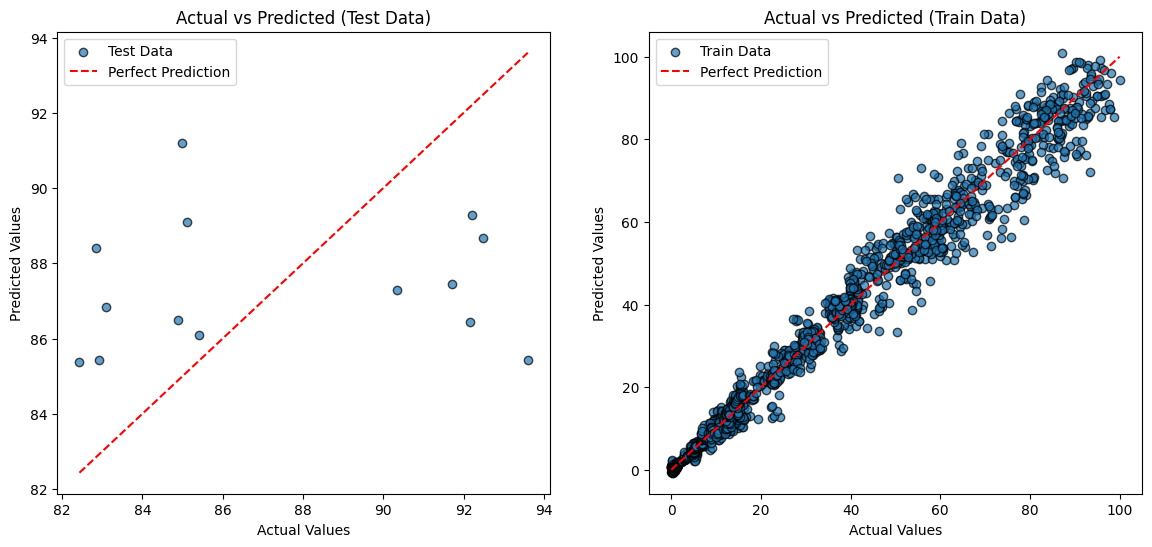

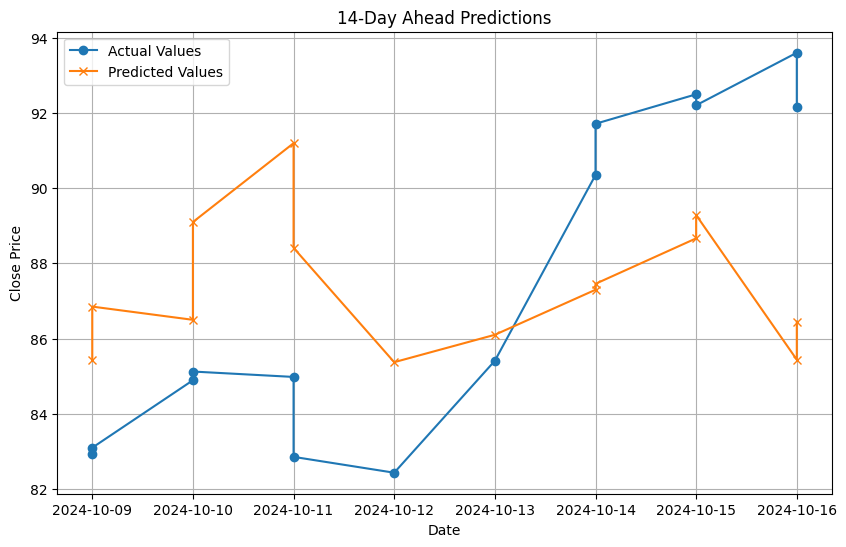

Directional Accuracy: 64.29%


In [28]:
# Creating metrics to evaluate model performance
# See outputs below

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds))
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_preds))

test_r2 = r2_score(y_test, y_test_preds)
train_r2 = r2_score(y_train, y_train_preds)

print(f"Test R^2: {test_r2:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.2f}, Train RMSE: {train_rmse:.2f}")

# Plotting
plt.figure(figsize=(14, 6))

# Test data
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_preds, alpha=0.7, edgecolor='k', label='Test Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),
         y_test.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Test Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

# Train data
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_preds, alpha=0.7,
            edgecolor='k', label='Train Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(),
         y_train.max()], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (Train Data)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()


plt.show()

# showing accuracy of predictions:
plt.figure(figsize=(10, 6))
plt.plot(df_percentage['Date'].iloc[-14:], y_test,
         label='Actual Values', marker='o')
plt.plot(df_percentage['Date'].iloc[-14:], y_test_preds,
         label='Predicted Values', marker='x')
plt.title('14-Day Ahead Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid()

# plt.xticks(df_percentage_vit['Date'][::5], rotation=45) #Had to adjust date interval to avoid overcrowing the x-axis
plt.show()


# Importantly, was the model able to predict the direction of the price movement?
y_test_preds_series = pd.Series(y_test_preds, index=y_test.index)

# Did it go up or down?
direction_actual = np.sign(y_test.diff().fillna(0))
direction_predicted = np.sign(y_test_preds_series.diff().fillna(0))

# Compare the predicted direction to the actual direction
correct_direction = (direction_actual == direction_predicted).sum()

# Calculate the percentage of correct directional predictions
directional_accuracy = correct_direction / len(y_test) * 100

print(f'Directional Accuracy: {directional_accuracy:.2f}%')